# Categorical VAE with Gumbel-Softmax

Partial implementation of the paper [Categorical Reparameterization with Gumbel-Softmax](https://arxiv.org/abs/1611.01144) 

A categorical VAE with discrete latent variables. Tensorflow version is 1.14.0.

# 1. Imports and Helper Functions

In [2]:
import tensorflow as tf
from tensorflow.examples.tutorials.mnist import input_data
import matplotlib.pyplot as plt
import numpy as np
%matplotlib inline
slim=tf.contrib.slim
Bernoulli = tf.contrib.distributions.Bernoulli

In [3]:
def sample_gumbel(shape, eps=1e-20): 
    """Sample from Gumbel(0, 1)"""
    U = tf.random_uniform(shape,minval=0,maxval=1)
    return -tf.log(-tf.log(U + eps) + eps)

def gumbel_softmax_sample(logits, temperature): 
    """ Draw a sample from the Gumbel-Softmax distribution"""
    y = logits + sample_gumbel(tf.shape(logits))
    return tf.nn.softmax( y / temperature)

def gumbel_softmax(logits, temperature, hard=False):
    """Sample from the Gumbel-Softmax distribution and optionally discretize.
    Args:
        logits: [batch_size, n_class] unnormalized log-probs
        temperature: non-negative scalar
        hard: if True, take argmax, but differentiate w.r.t. soft sample y
    Returns:
        [batch_size, n_class] sample from the Gumbel-Softmax distribution.
        If hard=True, then the returned sample will be one-hot, otherwise it will
        be a probabilitiy distribution that sums to 1 across classes
    """
    y = gumbel_softmax_sample(logits, temperature)
    if hard:
        k = tf.shape(logits)[-1]
        #y_hard = tf.cast(tf.one_hot(tf.argmax(y,1),k), y.dtype)
        y_hard = tf.cast(tf.equal(y,tf.reduce_max(y,1,keep_dims=True)),y.dtype)
        y = tf.stop_gradient(y_hard - y) + y
    return y

# 2. Build Model

In [4]:
K=10 # number of classes
N=30 # number of categorical distributions

In [5]:
# input image x (shape=(batch_size,784))
x = tf.placeholder(tf.float32,[None,784])
# variational posterior q(y|x), i.e. the encoder (shape=(batch_size,200))
net = slim.stack(x,slim.fully_connected,[512,256])
# unnormalized logits for N separate K-categorical distributions (shape=(batch_size*N,K))
logits_y = tf.reshape(slim.fully_connected(net,K*N,activation_fn=None),[-1,K])
q_y = tf.nn.softmax(logits_y)
log_q_y = tf.log(q_y+1e-20)
# temperature
tau = tf.Variable(5.0,name="temperature")
# sample and reshape back (shape=(batch_size,N,K))
# set hard=True for ST Gumbel-Softmax
y = tf.reshape(gumbel_softmax(logits_y,tau,hard=False),[-1,N,K])
# generative model p(x|y), i.e. the decoder (shape=(batch_size,200))
net = slim.stack(slim.flatten(y),slim.fully_connected,[256,512])
logits_x = slim.fully_connected(net,784,activation_fn=None)
# (shape=(batch_size,784))
p_x = Bernoulli(logits=logits_x)

Instructions for updating:
Use keras.layers.flatten instead.
Instructions for updating:
The TensorFlow Distributions library has moved to TensorFlow Probability (https://github.com/tensorflow/probability). You should update all references to use `tfp.distributions` instead of `tf.distributions`.
Instructions for updating:
The TensorFlow Distributions library has moved to TensorFlow Probability (https://github.com/tensorflow/probability). You should update all references to use `tfp.distributions` instead of `tf.distributions`.


In [6]:
# loss and train ops
kl_tmp = tf.reshape(q_y*(log_q_y-tf.log(1.0/K)),[-1,N,K])
KL = tf.reduce_sum(kl_tmp,[1,2])
elbo=tf.reduce_sum(p_x.log_prob(x),1) - KL

Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


In [7]:
loss=tf.reduce_mean(-elbo)
lr=tf.constant(0.001)
train_op=tf.train.AdamOptimizer(learning_rate=lr).minimize(loss,var_list=slim.get_model_variables())
init_op=tf.initialize_all_variables()

Instructions for updating:
Use `tf.global_variables_initializer` instead.


# 3. Train

In [8]:
# get data
data = input_data.read_data_sets('/tmp/', one_hot=True).train 

Instructions for updating:
Please use alternatives such as official/mnist/dataset.py from tensorflow/models.
Instructions for updating:
Please write your own downloading logic.
Instructions for updating:
Please use urllib or similar directly.
Successfully downloaded train-images-idx3-ubyte.gz 9912422 bytes.
Instructions for updating:
Please use tf.data to implement this functionality.
Extracting /tmp/train-images-idx3-ubyte.gz
Successfully downloaded train-labels-idx1-ubyte.gz 28881 bytes.
Instructions for updating:
Please use tf.data to implement this functionality.
Extracting /tmp/train-labels-idx1-ubyte.gz
Instructions for updating:
Please use tf.one_hot on tensors.
Successfully downloaded t10k-images-idx3-ubyte.gz 1648877 bytes.
Extracting /tmp/t10k-images-idx3-ubyte.gz
Successfully downloaded t10k-labels-idx1-ubyte.gz 4542 bytes.
Extracting /tmp/t10k-labels-idx1-ubyte.gz
Instructions for updating:
Please use alternatives such as official/mnist/dataset.py from tensorflow/models.


In [9]:
BATCH_SIZE=100
NUM_ITERS=50000
tau0=1.0 # initial temperature
np_temp=tau0
np_lr=0.001
ANNEAL_RATE=0.00003
MIN_TEMP=0.5

In [10]:
dat=[]
sess=tf.InteractiveSession()
sess.run(init_op)
for i in range(1,NUM_ITERS):
  np_x,np_y=data.next_batch(BATCH_SIZE)
  _,np_loss=sess.run([train_op,loss],{
      x:np_x,
      tau:np_temp,
      lr:np_lr
    })
  if i % 100 == 1:
    dat.append([i,np_temp,np_loss])
  if i % 1000 == 1:
    np_temp=np.maximum(tau0*np.exp(-ANNEAL_RATE*i),MIN_TEMP)
    np_lr*=0.9
  if i % 5000 == 1:
    print('Step %d, ELBO: %0.3f' % (i,-np_loss))

Step 1, ELBO: -544.176
Step 5001, ELBO: -105.885
Step 10001, ELBO: -101.143
Step 15001, ELBO: -99.791
Step 20001, ELBO: -98.322
Step 25001, ELBO: -105.964
Step 30001, ELBO: -99.552
Step 35001, ELBO: -96.576
Step 40001, ELBO: -102.258
Step 45001, ELBO: -100.370


## save to animation

In [11]:
np_x1,_=data.next_batch(100)
np_x2,np_y1 = sess.run([p_x.mean(),y],{x:np_x1})

In [12]:
import matplotlib.animation as animation

In [13]:
def save_anim(data,figsize,filename):
  fig=plt.figure(figsize=(figsize[1]/10.0,figsize[0]/10.0))
  im = plt.imshow(data[0].reshape(figsize),cmap=plt.cm.gray,interpolation='none')
  plt.gca().set_axis_off()
  #fig.tight_layout()
  fig.subplots_adjust(left=0, bottom=0, right=1, top=1, wspace=None, hspace=None)
  def updatefig(t):
    im.set_array(data[t].reshape(figsize))
    return im,
  anim=animation.FuncAnimation(fig, updatefig, frames=100, interval=50, blit=True, repeat=True)
  Writer = animation.writers['imagemagick']
  writer = Writer(fps=1, metadata=dict(artist='Me'), bitrate=1800)
  anim.save(filename, writer=writer)
  return

In [14]:
# save_anim(np_x1,(28,28),'x0.gif')
# save_anim(np_y1,(N,K),'y.gif')
# save_anim(np_x2,(28,28),'x1.gif')

# 4. Plot Training Curves

In [15]:
dat=np.array(dat).T

Text(0, 0.5, '-ELBO')

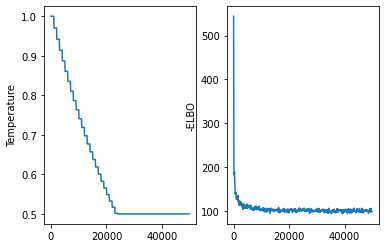

In [16]:
f,axarr=plt.subplots(1,2)
axarr[0].plot(dat[0],dat[1])
axarr[0].set_ylabel('Temperature')
axarr[1].plot(dat[0],dat[2])
axarr[1].set_ylabel('-ELBO')

# 5. Unconditional Generation

This consists of sampling from the prior $p_\theta(y)$ and passing it through the generative model.

In [17]:
M=100*N
np_y = np.zeros((M,K))
np_y[range(M),np.random.choice(K,M)] = 1
np_y = np.reshape(np_y,[100,N,K])

In [18]:
x_p=p_x.mean()
np_x= sess.run(x_p,{y:np_y})

In [19]:
np_y = np_y.reshape((10,10,N,K))
np_y = np.concatenate(np.split(np_y,10,axis=0),axis=3)
np_y = np.concatenate(np.split(np_y,10,axis=1),axis=2)
y_img = np.squeeze(np_y)

In [20]:
np_x = np_x.reshape((10,10,28,28))
# split into 10 (1,10,28,28) images, concat along columns -> 1,10,28,280
np_x = np.concatenate(np.split(np_x,10,axis=0),axis=3)
# split into 10 (1,1,28,280) images, concat along rows -> 1,1,280,280
np_x = np.concatenate(np.split(np_x,10,axis=1),axis=2)
x_img = np.squeeze(np_x)

Text(0.5, 1.0, 'Generated Images')

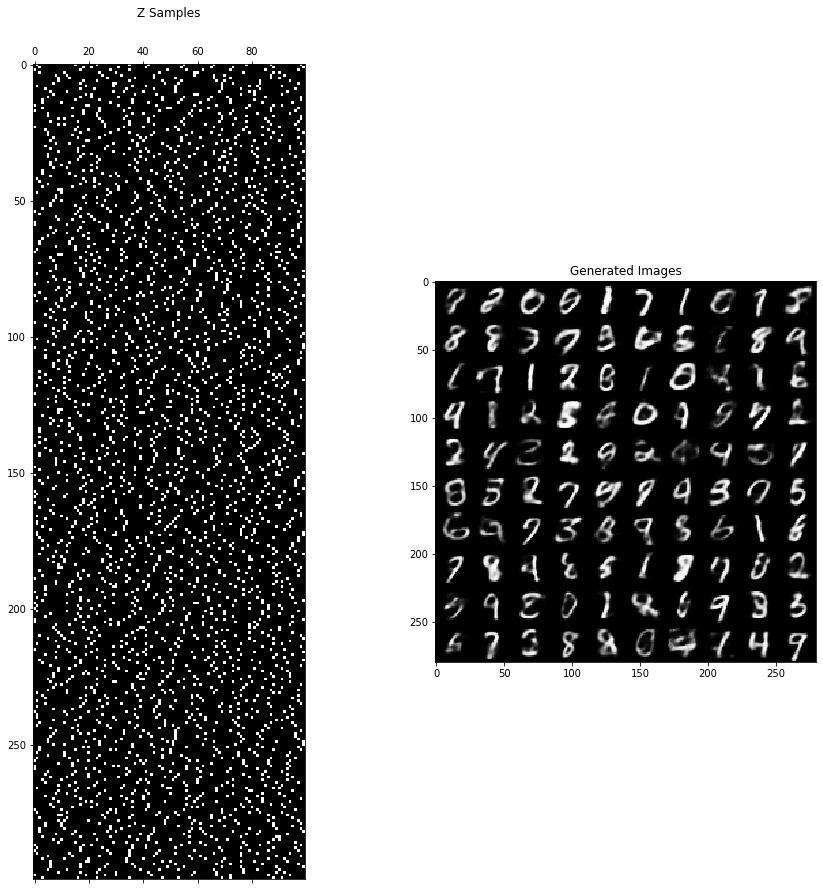

In [21]:
f,axarr=plt.subplots(1,2,figsize=(15,15))
# samples
axarr[0].matshow(y_img,cmap=plt.cm.gray)
axarr[0].set_title('Z Samples')
# reconstruction
axarr[1].imshow(x_img,cmap=plt.cm.gray,interpolation='none')
axarr[1].set_title('Generated Images')

In [23]:
# f.tight_layout()
# f.savefig('code.png')